In [1024]:
import random
import numpy as np
import copy
class Node:
    def __init__(self,speed,cpu,id,BlkID,block):
        self.cpu_type = cpu
        self.speed = speed
        self.id = id
     
        self.txPool = set()
        self.txStatus = {}
        self.bitcoinTree = {}
        self.bitcoinTree[BlkID] = block
        self.currentHead = BlkID
class Event:
    def __init__(self,event_type,time,peer_id,parameters,fromNode,newBlock,tx):
        self.eventType = event_type
        self.time = time
        self.peer_id = peer_id
        self.parameters = parameters
        self.newBlock = newBlock
        self.fromNode = fromNode
        self.tx = tx
    
    def __lt__(self,other):
        return self.time < other.time


class Block:
    def __init__(self,blkType,BlkID,prevBlkID, createdAt, txList,amount,timeArrival):
        self.blkType = blkType
        self.BlkID = BlkID
        self.prevBlkID = prevBlkID
        self.createdAt = createdAt
        self.txList = txList
        self.amountDic = amount
        self.timeArrival = timeArrival

In [903]:
####### Initialization Functions

import random
import string
import secrets


def initialize(num_peers,z0,z1):
    
    peers =[]
    amount={}
    for peer_id in range(num_peers):
        amount[peer_id] = np.random.randint(1000,10000)
    
    

    genesisBlock = Block('genesis',genUID(),None,0,None,amount,0)
    for peer_id in range(num_peers):
        
        temp_z0 = np.random.uniform(0,1)
        temp_z1 = np.random.uniform(0,1)
        speed =  "slow" if temp_z0 < z0 else  "fast" 
        cpu =  "low CPU" if temp_z1 < z1  else "high CPU"
        
        peers.append(Node(speed,cpu,peer_id,genesisBlock.BlkID,copy.deepcopy(genesisBlock)))
        
    return peers

def check_connected(num_peers,cn):
    visited=[0 for i in range(num_peers)]
    index=0
    visited = dfs(index,cn,visited)
    return all(visited)
        

def dfs(index,connected,visited):
    visited[index] = 1
    for peer in connected[index]:
        if visited[peer]==0:
            dfs(peer,connected,visited)
    return visited    
    

def make_connections(num_peers,startRange,stopRange):
    
    pij = {}
    connected = [[] for i in range(num_peers)]
    for i in range(0,num_peers):
        
        edges = np.random.randint(startRange,stopRange+1)
        if len(connected[i]) in range(startRange,stopRange+1):
            continue
            
        while (len(connected[i]) < edges ):
            node_id = random.choice([index for index in range(num_peers) if index not in connected[i]])
            if node_id!= i and len(connected[node_id]) < stopRange:
                    ij = np.random.uniform(1e-2,0.5)
                    pij[str(i)+"-"+str(node_id)] = ij
                    pij[str(node_id)+"-"+str(i)] = ij
                    connected[i].append(node_id)
                    connected[node_id].append(i)         
            
    if check_connected(num_peers,connected):
        return (connected,pij)
    else:
        make_connections(num_peers,startRange,stopRange)

In [1205]:
######### Transaction Functions

def generate_transaction(peer_id,parameters,aTime,eventQueue):
    meanTime = 10
    peers = parameters['peers']
    num_peers = parameters['num_peers']
    network_topology = parameters['network_topology']
    pij = parameters['pij']
    
    txid= ''.join(secrets.choice(string.ascii_uppercase + string.ascii_lowercase) for i in range(7))
    idy = None
    while(1) :
        idy = np.random.randint(0,num_peers)
        if idy!= peer_id:
            break
    
    amount = np.random.randint(1,101)
    idx = peer_id
    # peer[peer_id].credit -= amount
    
    tx = txid+": "+str(idx)+" pays "+str(idy)+" "+str(amount)+" coins"
    mlen = 8e+3

    
    peers[peer_id].txPool.add(tx)
    peers[peer_id].txStatus[tx]='fresh'
    
    
    for adj_node in network_topology[peer_id]:
        
        # print(f'GenTx fromNode {peer_id} adj {adj_node} {tx}')
        
        cij = 1e+8 if ( peers[peer_id].speed == 'fast' and peers[adj_node].speed == 'fast') else 5e+6
        plight = pij[str(idx)+"-"+str(adj_node)]
        dij = np.random.exponential(scale= (96e+3/cij))
        newTime = aTime + plight + (mlen/cij) + dij
        fromNode = peer_id
        newEvent = Event("receiveTx",newTime, adj_node, parameters,fromNode , None,tx )
        eventQueue.put(newEvent)
        
    arrivalTime = aTime + np.random.exponential(scale=meanTime)
    eventQueue.put(Event("generate_transaction",arrivalTime,peer_id,parameters,None,None,None))
        
        

def receiveTx(peer_id,parameters,aTime,fromNode,tx,eventQueue):
    
    peer = parameters['peers']
    num_peers = parameters['num_peers']
    network_topology = parameters['network_topology']
    pij = parameters['pij']    
    
    if tx in peer[peer_id].txPool:
        return 
    
    peer[peer_id].txPool.add(tx)
    mlen = 8e+3
    
    for adj_node in network_topology[peer_id]:
        
        if adj_node!= fromNode:
            # print(f'ReceiveTx fromNode {fromNode} adj {adj_node} {tx}')
            cij = 1e+8 if ( peer[peer_id].speed == 'fast' and peer[adj_node].speed == 'fast') else 5e+6
            plight = pij[str(peer_id)+"-"+str(adj_node)]
            dij = np.random.exponential(scale= (96e+3/cij))
            newTime = aTime + plight + (mlen/cij) + dij
            newFromNode = peer_id
            newEvent = Event("receiveTx",newTime, adj_node, parameters,newFromNode,None,tx )
            eventQueue.put(newEvent)


In [1144]:
# ### Block Functions

# def compute_hashPower(peer):
#     hpw=0
#     for node in peer:
#         hpw += 10 if node.cpu_type == "high CPU" else 1
        
#     return 1/hpw
    
# def genUID():
#     return ''.join(secrets.choice(string.ascii_uppercase + string.ascii_lowercase) for i in range(8))
        

# def checkValidTx(tmpTx,amountDic,peer_id,parameters):
    
#     peers = parameters['peers']
#     currentBlock = peers[peer_id].bitcoinTree[peers[peer_id].currentHead]
#     # print(currentBlock.type)
#     # print("peer_id",peer_id)
#     # print("prevBlock",currentBlock.prevBlkID)
#     while ( currentBlock.blkType != 'genesis' ):
#         txList = currentBlock.txList
        
#         if tmpTx in txList:
#             return False
#         currentBlock = peers[peer_id].bitcoinTree[currentBlock.prevBlkID]
        
        
    
#     tmp = tmpTx.split()
#     idx = int(tmp[1])
#     if tmp[2] == 'mines':
#         amountDic[idx] +=50
#         return True
    
#     idy = int(tmp[3])
#     coins = int(tmp[4])
#     if amountDic[idx] >= coins:
#         amountDic[idx] -=coins
#         amountDic[idy] +=coins
#         return True

#     return False

            
# def mineBlock(peer_id,parameters,aTime,eventQueue):

#     peers = parameters['peers']
#     num_peers = parameters['num_peers']
#     bitcoinTree = peers[peer_id].bitcoinTree


    
#     txPool = peers[peer_id].txPool
#     amountDic = peers[peer_id].bitcoinTree[peers[peer_id].currentHead].amountDic.copy()
#     txList = set()
#     hashpw = parameters['hashpw']
#     hpw = 10*hashpw if peers[peer_id].cpu_type == 'high CPU' else hashpw
#     numPops =0
#     txid= ''.join(secrets.choice(string.ascii_uppercase + string.ascii_lowercase) for i in range(7)) 
    
#     tx = txid+": "+str(peer_id)+" mines 50 coins"
    
    
    
#     while( len(txPool) > 0 and numPops < 999):
#         tmpTx = txPool.pop()
#         ### check validTxs 
#         if checkValidTx(tmpTx,amountDic, peer_id,parameters):
#             txList.add(tmpTx)
#             numPops +=1
            
#     txList.add(tx)
#     amountDic[peer_id] +=50
    
#     avgTime = 200
#     time_Tk = np.random.exponential(scale=avgTime/hpw)
#     newTime = aTime + time_Tk
#     newBlock = Block('valid',genUID(),peers[peer_id].currentHead,newTime,txList,amountDic,newTime)
#     newEvent = Event("genBlock",newTime,peer_id, parameters,None,newBlock,None)
#     eventQueue.put(newEvent)
    

#     for blockID in bitcoinTree.keys():
#         if bitcoinTree[blockID].blkType == "cached":
#             block = bitcoinTree[blockID]
#             newEvent = Event("receiveBlock",aTime, peer_id, parameters,peer_id,block,None )
#             eventQueue.put(newEvent)
    
    
    
# def genBlock(peer_id,parameters,aTime,newBlock,eventQueue):
    
#     peers = parameters['peers']
    
#     if peers[peer_id].currentHead == newBlock.prevBlkID :
#         peers[peer_id].bitcoinTree[newBlock.BlkID] = copy.deepcopy(newBlock)
#         peers[peer_id].currentHead = newBlock.BlkID     
        
#         # fromNode= peer_id 
       
#         newEvent = Event("broadcastBlock",aTime,peer_id,parameters,None,newBlock,None)
#         eventQueue.put(newEvent)
        
        
#     else:
        
#         while ( len(newBlock.txList) > 0 ):
#             peers[peer_id].txPool.add(newBlock.txList.pop())
            
#         eventQueue.put(Event("mineBlock",aTime,peer_id,parameters,None,None,None))
    
  
        
    
    
# def broadcastBlock(peer_id,parameters,aTime,fromNode,newBlock,eventQueue):
    
#     peers = parameters['peers']
#     network_topology = parameters['network_topology']
#     pij = parameters['pij']

#     # if newBlock.BlkID in peers[peer_id].bitcoinTree.keys():
#     #     return
    
#     mlen = len(newBlock.txList)*8e+3
    
    
#     # print(mlen) ## max 1mb
    
#     for adj_node in network_topology[peer_id]:
        
#         if adj_node!= fromNode:
              
#             cij = 1e+8 if ( peers[peer_id].speed == 'fast' and peers[adj_node].speed == 'fast') else 5e+6
#             plight = pij[str(peer_id)+"-"+str(adj_node)]
#             dij = np.random.exponential(scale= (96e+3/cij))
#             newTime = aTime + plight + (mlen/cij) + dij
#             newFromNode = peer_id
#             newEvent = Event("receiveBlock",newTime, adj_node, parameters,newFromNode,newBlock,None )
#             eventQueue.put(newEvent)
       
#     newEvent = Event('mineBlock',aTime,peer_id,parameters,None,None,None)
#     eventQueue.put(newEvent)  

# def getValidBlockAndDepth(peer_id,parameters,newBlock):
   
#     peers = parameters['peers']
#     bitcoinTree = peers[peer_id].bitcoinTree
#     tempBlock = bitcoinTree[newBlock.BlkID]
#     depth = 0
#     while( tempBlock.blkType != 'valid' and tempBlock.blkType !='genesis'):
#         depth +=1
#         tempBlock = bitcoinTree[tempBlock.prevBlkID]
   
#     return (tempBlock , depth)
    
    
# def getDepth(peer_id,parameters,block):
    

#     peers = parameters['peers']
#     bitcoinTree = peers[peer_id].bitcoinTree
#     currentBlock = bitcoinTree[peers[peer_id].currentHead]
    
#     tempBlock = bitcoinTree[currentBlock.BlkID]
#     depth = 0

#     ##### may be not found case
    
#     while (tempBlock.BlkID != block.BlkID):
#         depth +=1
#         tempBlock = bitcoinTree[tempBlock.prevBlkID]
    
#     return depth
    
    
# def makeOrphanAndReleaseTx(peer_id,parameters,validBlock):
#     peers = parameters['peers']
#     bitcoinTree = peers[peer_id].bitcoinTree
#     tempBlock = bitcoinTree[peers[peer_id].currentHead]
    
#     while tempBlock.BlkID != validBlock.BlkID :
#         tempBlock.blkType = "orphan"
#         txList = tempBlock.txList.copy()
#         while len(txList) > 0 :
#             tmpTx = txList.pop()
#             tmp = tmpTx.split()
#             if tmp[2] != "mines":
#                 peers[peer_id].txPool.add(tmpTx)
            
#         tempBlock = bitcoinTree[tempBlock.prevBlkID]
   
 


# def makeValidAndProcessTx(peer_id,parameters,validBlock):
    
#     peers = parameters['peers']
#     bitcoinTree = peers[peer_id].bitcoinTree
#     tempBlock = bitcoinTree[peers[peer_id].currentHead]
    
#     while tempBlock.BlkID != validBlock.BlkID :
#         tempBlock.blkType = 'valid'
#         txList = tempBlock.txList.copy()
#         while len(txList) > 0:
#             tmpTx = txList.pop()
#             tmp = tmpTx.split()
#             if tmp[2] != 'mines':
#                 try:
#                     peers[peer_id].txPool.remove(tmpTx)
#                 except:
#                     continue
            
#         tempBlock = bitcoinTree[tempBlock.prevBlkID]
        

    


# def checkValidBlock(peer_id,parameters,block):
    
#     peers = parameters['peers']
    
    
#     if block.prevBlkID not in peers[peer_id].bitcoinTree.keys() :
#         # print("Earlier not Came")
#         # peers = parameters['peers']
#         # block.blkType = "cached"
#         # peers[peer_id].bitcoinTree[block.BlkID] = copy.deepcopy(block)
#         # print("cached block",block.BlkID," at peer id ",peer_id)
#         return False
    
#     if  peers[peer_id].bitcoinTree[block.prevBlkID].blkType=='cached':
#         # peers = parameters['peers']
#         # block.blkType = "cached"
#         # peers[peer_id].bitcoinTree[block.BlkID] = copy.deepcopy(block)
#         # print("cached because previous block cached",block.BlkID," at peer id ",peer_id)
#         return False
        
        
    
    
#     amountDic = peers[peer_id].bitcoinTree[block.prevBlkID].amountDic.copy()
#     txList = block.txList.copy()
    
#     for tx in txList:
#         if checkValidTx(tx,amountDic,peer_id,parameters)==False :
#             return False
        
#     if amountDic == block.amountDic :
#         # print("amount Matched and Valid tx",True)
#         return True
#     else:
#         print("amount NOt Matched",False)
#         return False
    
    
# def receiveBlock(peer_id,parameters,aTime,fromNode,newBlock,eventQueue):
    
#     peers = parameters['peers']
    
    
#     if newBlock.BlkID in peers[peer_id].bitcoinTree.keys():
#         return
#     ###############
# #     peers[peer_id].bitcoinTree[newBlock.BlkID] = copy.deepcopy(newBlock)
# #     peers[peer_id].currentHead = newBlock.BlkID
# #     newEvent = Event("broadcastBlock",aTime,peer_id,parameters,fromNode,newBlock,None)
# #     eventQueue.put(newEvent)
# #     newEvent = Event("mineBlock",aTime,peer_id,parameters,None,None,None)
# #     eventQueue.put(newEvent)
# #     return
    
    
# #     ###############
    
#     # for a in peers:
#     #     backTrack(a.id,parameters,peers[a.id].currentHead)
    
#     if newBlock.blkType != 'cached':
#         newBlock.timeArrival = aTime
    
#     if checkValidBlock(peer_id,parameters,newBlock)==False:
#         return
#     newBlock.blkType = 'valid'
    
#     newBlock.timeArrival = aTime
#       ###check here
    
#     if peers[peer_id].currentHead == newBlock.prevBlkID :
        
#         #### check valid Tx's
#         peers[peer_id].bitcoinTree[newBlock.BlkID] = copy.deepcopy(newBlock)
#         peers[peer_id].currentHead = newBlock.BlkID
  
#         #### remove Tx from txPool
#         txList = newBlock.txList.copy()
            
#         while len(txList) > 0:
#             try:
#                 peers[peer_id].txPool.remove(txList.pop())
#             except:
#                 continue

#         newEvent = Event("broadcastBlock",aTime,peer_id,parameters,fromNode,newBlock,None)
#         eventQueue.put(newEvent)
#         newEvent = Event("mineBlock",aTime,peer_id,parameters,None,None,None)
#         eventQueue.put(newEvent)

#     else :
        
#         if newBlock.prevBlkID not in  peers[peer_id].bitcoinTree.keys():
#             return
        
#         if peers[peer_id].bitcoinTree[newBlock.prevBlkID].blkType == 'orphan':
            
#             newBlock.blkType = "orphan"
#             peers[peer_id].bitcoinTree[newBlock.BlkID] = copy.deepcopy(newBlock)
            
#             # print("BACKTRACK after adding orphan above orphan")
#             # backTrack(peer_id,parameters,newBlock.BlkID)
            
#             (validBlock, depth ) = getValidBlockAndDepth(peer_id,parameters,newBlock)
            
# #             print(f"Got validBlock {validBlock.BlkID} at depth {depth}")
                
            
            
# #             print("BACKTRACK from current Head")
# #             backTrack(peer_id,parameters,peers[peer_id].currentHead)
            
#             validDepth = getDepth(peer_id,parameters,validBlock)
#             # print(f"Got validBlock {validBlock.BlkID} at depth {validDepth}")
            

#             if validDepth < depth :
#                 # print("ValidDepth is less so interchange")
#                 # print("original from currentHead")
#                 # tmpCurrentHead = peers[peer_id].currentHead
#                 # backTrack(peer_id,parameters,peers[peer_id].currentHead)
#                 # print("original from newBlock")
#                 # backTrack(peer_id,parameters,newBlock.BlkID)
                
#                 makeOrphanAndReleaseTx(peer_id,parameters,validBlock)
#                 peers[peer_id].currentHead = newBlock.BlkID
#                 peers[peer_id].bitcoinTree[newBlock.BlkID] = copy.deepcopy(newBlock)
#                 makeValidAndProcessTx(peer_id,parameters,validBlock)
                
                
#                 # print("original from currentHead new")
#                 # backTrack(peer_id,parameters,peers[peer_id].currentHead)
#                 # print("original from old CurrentHead")
#                 # backTrack(peer_id,parameters,tmpCurrentHead)
              
                
#                 newEvent = Event("mineBlock",aTime,peer_id,parameters,None,None,None)
#                 eventQueue.put(newEvent)
                
            
            
#             else:
#                 newBlock.blkType = "orphan"
#                 peers[peer_id].bitcoinTree[newBlock.BlkID] = copy.deepcopy(newBlock)

        
#         else:
            
#             newBlock.blkType = "orphan"
#             peers[peer_id].bitcoinTree[newBlock.BlkID] = copy.deepcopy(newBlock)

            
            

# def backTrack(peer_id,parameters,blkID):
#     print(f"Backtrack for peer {peer_id}")
#     peers = parameters['peers']
#     bitcoinTree = peers[peer_id].bitcoinTree
    
#     tmp = bitcoinTree[blkID]
    
#     while(tmp.blkType !='genesis'):
#         print(tmp.blkType,tmp.BlkID," pointing to ",tmp.prevBlkID)
#         tmp = bitcoinTree[tmp.prevBlkID]
    
#     print(tmp.blkType,tmp.BlkID," pointing to ",tmp.prevBlkID)
    
#     print()
#     print()
    
    
    
        
    

In [1145]:
# from queue import PriorityQueue
# # np.random.seed(15)
# # random.seed(5)
# z0 = np.random.uniform(0,1)
# z1 = np.random.uniform(0,1)
# num_peers = np.random.randint(4,5)
# startRange = 1
# stopRange = 3
# peers = initialize(num_peers,z0,z1)
# (network_topology,pij) = make_connections(num_peers,startRange,stopRange)
# l=[]
# for a in network_topology:
#     l.append(len(a))
#     print(a)

# l = np.array(l)
# print(l.max(),l.min())

# meanTime = 2
# hashpw = compute_hashPower(peers)
# parameters = {
#     "num_peers" : num_peers,
#     "peers" : peers,
#     "network_topology" : network_topology,
#     "pij" : pij ,
#     "hashpw" : hashpw
#     }


[2, 1, 3]
[0]
[0]
[0]
3 1


In [1217]:
### Block Functions Temp

def compute_hashPower(peer):
    hpw=0

    for node in peer:
        hpw += 10 if node.cpu_type == "high CPU" else 1
        
    return 1/hpw
    
def genUID():
    return ''.join(secrets.choice(string.ascii_uppercase + string.ascii_lowercase) for i in range(8))
        

def checkValidTx(tmpTx,amountDic,peer_id,parameters):
    
    peers = parameters['peers']
    currentBlock = peers[peer_id].bitcoinTree[peers[peer_id].currentHead]
    # print(currentBlock.type)
    # print("peer_id",peer_id)
    # print("prevBlock",currentBlock.prevBlkID)
    while ( currentBlock.blkType != 'genesis' ):
        txList = currentBlock.txList
        
        if tmpTx in txList:
            return False
        currentBlock = peers[peer_id].bitcoinTree[currentBlock.prevBlkID]
        
        
    
    tmp = tmpTx.split()
    idx = int(tmp[1])
    if tmp[2] == 'mines':
        amountDic[idx] +=50
        return True
    
    idy = int(tmp[3])
    coins = int(tmp[4])
    if amountDic[idx] >= coins:
        amountDic[idx] -=coins
        amountDic[idy] +=coins
        return True

    return False

            
def mineBlock(peer_id,parameters,aTime,eventQueue):

    peers = parameters['peers']
    num_peers = parameters['num_peers']
    bitcoinTree = peers[peer_id].bitcoinTree


    
    txPool = peers[peer_id].txPool
    amountDic = peers[peer_id].bitcoinTree[peers[peer_id].currentHead].amountDic.copy()
    txList = set()
    hashpw = parameters['hashpw']
    hpw = 10*hashpw if peers[peer_id].cpu_type == 'high CPU' else hashpw
    numPops =0
    txid= ''.join(secrets.choice(string.ascii_uppercase + string.ascii_lowercase) for i in range(7)) 
    
    tx = txid+": "+str(peer_id)+" mines 50 coins"
    
    
    
    while( len(txPool) > 0 and numPops < 999):
        tmpTx = txPool.pop()
        ### check validTxs 
        if checkValidTx(tmpTx,amountDic, peer_id,parameters):
            txList.add(tmpTx)
            numPops +=1
            
    txList.add(tx)
    amountDic[peer_id] +=50
    
    avgTime = 200
    time_Tk = np.random.exponential(scale=avgTime/hpw)
    newTime = aTime + time_Tk
    newBlock = Block('valid',genUID(),peers[peer_id].currentHead,newTime,txList,amountDic,newTime)
    newEvent = Event("genBlock",newTime,peer_id, parameters,None,newBlock,None)
    eventQueue.put(newEvent)
    

    
    
    
    
def genBlock(peer_id,parameters,aTime,newBlock,eventQueue):
    
    peers = parameters['peers']
    
    if peers[peer_id].currentHead == newBlock.prevBlkID :
        peers[peer_id].bitcoinTree[newBlock.BlkID] = copy.deepcopy(newBlock)
        peers[peer_id].currentHead = newBlock.BlkID     
        
        # fromNode= peer_id 
       
        newEvent = Event("broadcastBlock",aTime,peer_id,parameters,None,newBlock,None)
        eventQueue.put(newEvent)
        
        
    else:
        
        while ( len(newBlock.txList) > 0 ):
            peers[peer_id].txPool.add(newBlock.txList.pop())
            
        eventQueue.put(Event("mineBlock",aTime,peer_id,parameters,None,None,None))
    
  
        
    
    
def broadcastBlock(peer_id,parameters,aTime,fromNode,newBlock,eventQueue):
    
    peers = parameters['peers']
    network_topology = parameters['network_topology']
    pij = parameters['pij']

    # if newBlock.BlkID in peers[peer_id].bitcoinTree.keys():
    #     return
    
    mlen = len(newBlock.txList)*8e+3
    
    
    # print(mlen) ## max 1mb
    
    for adj_node in network_topology[peer_id]:
        
        if adj_node!= fromNode:
              
            cij = 1e+8 if ( peers[peer_id].speed == 'fast' and peers[adj_node].speed == 'fast') else 5e+6
            plight = pij[str(peer_id)+"-"+str(adj_node)]
            dij = np.random.exponential(scale= (96e+3/cij))
            newTime = aTime + plight + (mlen/cij) + dij
            newFromNode = peer_id
            newEvent = Event("receiveBlock",newTime, adj_node, parameters,newFromNode,newBlock,None )
            eventQueue.put(newEvent)
       
    newEvent = Event('mineBlock',aTime,peer_id,parameters,None,None,None)
    eventQueue.put(newEvent)  

def getValidBlockAndDepth(peer_id,parameters,newBlock):
   
    peers = parameters['peers']
    bitcoinTree = peers[peer_id].bitcoinTree
    tempBlock = bitcoinTree[newBlock.BlkID]
    depth = 0
    while( tempBlock.blkType != 'valid' and tempBlock.blkType !='genesis'):
        depth +=1
        tempBlock = bitcoinTree[tempBlock.prevBlkID]
   
    return (tempBlock , depth)
    
    
def getDepth(peer_id,parameters,block):
    

    peers = parameters['peers']
    bitcoinTree = peers[peer_id].bitcoinTree
    currentBlock = bitcoinTree[peers[peer_id].currentHead]
    
    tempBlock = bitcoinTree[currentBlock.BlkID]
    depth = 0

    ##### may be not found case
    
    while (tempBlock.BlkID != block.BlkID):
        depth +=1
        tempBlock = bitcoinTree[tempBlock.prevBlkID]
    
    return depth
    
    
def makeOrphanAndReleaseTx(peer_id,parameters,validBlock):
    peers = parameters['peers']
    bitcoinTree = peers[peer_id].bitcoinTree
    tempBlock = bitcoinTree[peers[peer_id].currentHead]
    
    while tempBlock.BlkID != validBlock.BlkID :
        tempBlock.blkType = "orphan"
        txList = tempBlock.txList.copy()
        while len(txList) > 0 :
            tmpTx = txList.pop()
            tmp = tmpTx.split()
            if tmp[2] != "mines":
                peers[peer_id].txPool.add(tmpTx)
            
        tempBlock = bitcoinTree[tempBlock.prevBlkID]
   
 


def makeValidAndProcessTx(peer_id,parameters,validBlock):
    
    peers = parameters['peers']
    bitcoinTree = peers[peer_id].bitcoinTree
    tempBlock = bitcoinTree[peers[peer_id].currentHead]
    
    while tempBlock.BlkID != validBlock.BlkID :
        tempBlock.blkType = 'valid'
        txList = tempBlock.txList.copy()
        while len(txList) > 0:
            tmpTx = txList.pop()
            tmp = tmpTx.split()
            if tmp[2] != 'mines':
                try:
                    peers[peer_id].txPool.remove(tmpTx)
                except:
                    continue
            
        tempBlock = bitcoinTree[tempBlock.prevBlkID]
        

    


def checkValidBlock(peer_id,parameters,block):
    
    peers = parameters['peers']
    
    
    if block.prevBlkID not in peers[peer_id].bitcoinTree.keys() :
        # print("Earlier not Came")
        peers = parameters['peers']
        block.blkType = "cached"
        peers[peer_id].bitcoinTree[block.BlkID] = copy.deepcopy(block)
        # print("cached block",block.BlkID," at peer id ",peer_id)
        return False
    
    if  peers[peer_id].bitcoinTree[block.prevBlkID].blkType=='cached':
        peers = parameters['peers']
        block.blkType = "cached"
        peers[peer_id].bitcoinTree[block.BlkID] = copy.deepcopy(block)
        # print("cached because previous block cached",block.BlkID," at peer id ",peer_id)
        return False
        
        
    
    
    amountDic = peers[peer_id].bitcoinTree[block.prevBlkID].amountDic.copy()
    txList = block.txList.copy()
    
    for tx in txList:
        if checkValidTx(tx,amountDic,peer_id,parameters)==False :
            print("because of tx")
            return False
        
    if amountDic == block.amountDic :
        # print("amount Matched and Valid tx",True)
        return True
    else:
        print("amount NOt Matched",False)
        return False
    
    
def receiveBlock(peer_id,parameters,aTime,fromNode,newBlock,eventQueue):
    
    peers = parameters['peers']
    
    
    if newBlock.BlkID in peers[peer_id].bitcoinTree.keys() and peers[peer_id].bitcoinTree[newBlock.BlkID].blkType !='cached':
        return
    ###############
    # newBlock.type = 'valid'
    # peers[peer_id].bitcoinTree[newBlock.BlkID] = copy.deepcopy(newBlock)
    # peers[peer_id].currentHead = newBlock.BlkID
    # newEvent = Event("broadcastBlock",aTime,peer_id,parameters,fromNode,newBlock,None)
    # eventQueue.put(newEvent)
    # newEvent = Event("mineBlock",aTime,peer_id,parameters,None,None,None)
    # eventQueue.put(newEvent)
    # return
    
    
    ###############
    
    # for a in peers:
    #     backTrack(a.id,parameters,peers[a.id].currentHead)
    
    if newBlock.blkType != 'cached':
        newBlock.timeArrival = aTime
    
    if checkValidBlock(peer_id,parameters,newBlock)==False:
      
        return
    
    newBlock.blkType = 'valid'
    
    newEvent = Event("broadcastBlock",aTime,peer_id,parameters,fromNode,newBlock,None)
    eventQueue.put(newEvent)
    
    for blockID in peers[peer_id].bitcoinTree.keys():
        if peers[peer_id].bitcoinTree[blockID].prevBlkID == newBlock.BlkID:
            newEvent = Event("receiveBlock",newTime,peer_id, parameters,fromNode,newBlock,None )
            eventQueue.put(newEvent)
            
    
    
    
  
      ###check here
    
    if peers[peer_id].currentHead == newBlock.prevBlkID :
        
        #### check valid Tx's
        peers[peer_id].bitcoinTree[newBlock.BlkID] = copy.deepcopy(newBlock)
        peers[peer_id].currentHead = newBlock.BlkID
  
        #### remove Tx from txPool
        txList = newBlock.txList.copy()
            
        while len(txList) > 0:
            try:
                peers[peer_id].txPool.remove(txList.pop())
            except:
                continue

        
        newEvent = Event("mineBlock",aTime,peer_id,parameters,None,None,None)
        eventQueue.put(newEvent)

    else :
        
        # if newBlock.prevBlkID not in  peers[peer_id].bitcoinTree.keys():
        #     return
        
        if peers[peer_id].bitcoinTree[newBlock.prevBlkID].blkType == 'orphan':
            
            newBlock.blkType = "orphan"
            peers[peer_id].bitcoinTree[newBlock.BlkID] = copy.deepcopy(newBlock)
            
            # print("BACKTRACK after adding orphan above orphan")
            # backTrack(peer_id,parameters,newBlock.BlkID)
            
            (validBlock, depth ) = getValidBlockAndDepth(peer_id,parameters,newBlock)
            
#             print(f"Got validBlock {validBlock.BlkID} at depth {depth}")
                
            
            
#             print("BACKTRACK from current Head")
#             backTrack(peer_id,parameters,peers[peer_id].currentHead)
            
            validDepth = getDepth(peer_id,parameters,validBlock)
            # print(f"Got validBlock {validBlock.BlkID} at depth {validDepth}")
            

            if validDepth < depth :
                # print("ValidDepth is less so interchange")
                # print("original from currentHead")
                # tmpCurrentHead = peers[peer_id].currentHead
                # backTrack(peer_id,parameters,peers[peer_id].currentHead)
                # print("original from newBlock")
                # backTrack(peer_id,parameters,newBlock.BlkID)
                
                makeOrphanAndReleaseTx(peer_id,parameters,validBlock)
                peers[peer_id].currentHead = newBlock.BlkID
                peers[peer_id].bitcoinTree[newBlock.BlkID] = copy.deepcopy(newBlock)
                makeValidAndProcessTx(peer_id,parameters,validBlock)
                
                
                # print("original from currentHead new")
                # backTrack(peer_id,parameters,peers[peer_id].currentHead)
                # print("original from old CurrentHead")
                # backTrack(peer_id,parameters,tmpCurrentHead)
              
                
                newEvent = Event("mineBlock",aTime,peer_id,parameters,None,None,None)
                eventQueue.put(newEvent)
                
            
            
            else:
                newBlock.blkType = "orphan"
                peers[peer_id].bitcoinTree[newBlock.BlkID] = copy.deepcopy(newBlock)

        
        else:
            
            newBlock.blkType = "orphan"
            peers[peer_id].bitcoinTree[newBlock.BlkID] = copy.deepcopy(newBlock)

            
            

def backTrack(peer_id,parameters,blkID):
    print(f"Backtrack for peer {peer_id}")
    peers = parameters['peers']
    bitcoinTree = peers[peer_id].bitcoinTree
    
    tmp = bitcoinTree[blkID]
    
    while(tmp.blkType !='genesis'):
        print(tmp.blkType,tmp.BlkID," pointing to ",tmp.prevBlkID)
        tmp = bitcoinTree[tmp.prevBlkID]
    
    print(tmp.blkType,tmp.BlkID," pointing to ",tmp.prevBlkID)
    
    print()
    print()
    
    
    
        
    

In [1218]:
from queue import PriorityQueue
# np.random.seed(15)
# random.seed(5)
z0 = np.random.uniform(0,1)
z1 = np.random.uniform(0,1)
num_peers = np.random.randint(4,5)
startRange = 1
stopRange = 3
peers = initialize(num_peers,z0,z1)
(network_topology,pij) = make_connections(num_peers,startRange,stopRange)
l=[]
for a in network_topology:
    l.append(len(a))
    print(a)

l = np.array(l)
print(l.max(),l.min())

meanTime = 2
hashpw = compute_hashPower(peers)
parameters = {
    "num_peers" : num_peers,
    "peers" : peers,
    "network_topology" : network_topology,
    "pij" : pij ,
    "hashpw" : hashpw
    }


eventQueue = PriorityQueue()
for peer_id in range(num_peers):

    arrivalTime=0
    # for transaction in range(1):
    arrivalTime =np.random.exponential(scale=meanTime)
    eventQueue.put(Event("generate_transaction",arrivalTime,peer_id,parameters,None,None,None))
    
    eventQueue.put(Event("mineBlock",2,peer_id,parameters,None,None,None))

c=0  
import os
try:
    os.remove("file.txt")
except:
    pass
f = open("file.txt", "a")

while not eventQueue.empty():
    next_schedule = eventQueue.get()
    c+=1
    
    if ( c > 51110 ):
        break
    
    
    
    
    # print(next_schedule.time,next_schedule.peer_id,next_schedule.type,)
    if next_schedule.eventType == "generate_transaction" :
        generate_transaction(next_schedule.peer_id,next_schedule.parameters,next_schedule.time,eventQueue)
        f.write(str(next_schedule.time)+" "+str(next_schedule.peer_id)+" "+next_schedule.eventType+"\n")
       
        
    if next_schedule.eventType == 'receiveTx':
        receiveTx(next_schedule.peer_id,next_schedule.parameters,next_schedule.time,next_schedule.fromNode,next_schedule.tx,eventQueue)
        f.write(str(next_schedule.time)+" from "+str(next_schedule.fromNode)+" to "+str(next_schedule.peer_id)+" "+next_schedule.tx+"\n")
       
        
        
    if next_schedule.eventType == 'mineBlock':
        mineBlock(next_schedule.peer_id,next_schedule.parameters,next_schedule.time,eventQueue)
        f.write(str(next_schedule.time)+" "+str(next_schedule.peer_id)+" "+next_schedule.eventType+"\n")
        
        
        
    if next_schedule.eventType == 'genBlock':
        genBlock(next_schedule.peer_id,next_schedule.parameters,next_schedule.time,next_schedule.newBlock,eventQueue)
        f.write(str(next_schedule.time)+" "+str(next_schedule.peer_id)+" "+next_schedule.eventType+"\n")
    
    if next_schedule.eventType == 'broadcastBlock':
        broadcastBlock(next_schedule.peer_id,next_schedule.parameters,next_schedule.time,next_schedule.fromNode,next_schedule.newBlock,eventQueue)
        f.write(str(next_schedule.time)+" "+str(next_schedule.peer_id)+" "+next_schedule.eventType+"\n")
        
        
    if next_schedule.eventType == 'receiveBlock':
        receiveBlock(next_schedule.peer_id,next_schedule.parameters,next_schedule.time,next_schedule.fromNode,next_schedule.newBlock,eventQueue)
        f.write(str(next_schedule.time)+" from "+str(next_schedule.fromNode)+" to "+str(next_schedule.peer_id)+" "+next_schedule.eventType+"\n")
f.close()

[2, 1, 3]
[0]
[0]
[0]
3 1


In [1219]:
for a in peers:
    valid =0
    invalid=0
    cached=0
    for k in a.bitcoinTree:
       
        if a.bitcoinTree[k].blkType == 'valid':
            valid +=1
        elif a.bitcoinTree[k].blkType == 'cached':
            cached+=1
        else:

            invalid+=1
    print(f' peer_id {a.id} has {valid} valid blocks and {invalid} invalid {cached} cached blocks {valid+cached+invalid} overall blocks')
            
        

 peer_id 0 has 408 valid blocks and 5 invalid 0 cached blocks 413 overall blocks
 peer_id 1 has 408 valid blocks and 5 invalid 0 cached blocks 413 overall blocks
 peer_id 2 has 408 valid blocks and 5 invalid 0 cached blocks 413 overall blocks
 peer_id 3 has 408 valid blocks and 5 invalid 0 cached blocks 413 overall blocks


In [1204]:
for a in range(4):
    print(len(peers[a].txPool))

1
3
3
0


In [1156]:
# logfile = open('file.txt')
# lines = logfile.readlines()
# cnt=0
# blkGenDict = dict()
# for line in lines:
#     records = line.split()
#     if records[2] == 'mineBlock':
#         print(line)
#         cnt+=1
#         if int(records[1]) in blkGenDict.keys():
#             blkGenDict[int(records[1])] = blkGenDict[int(records[1])] + 1
#         else:
#             blkGenDict[int(records[1])] = 0
# print('Number of Blocks generated ', cnt)

In [1157]:
ij = np.random.uniform(1e-2,0.5)

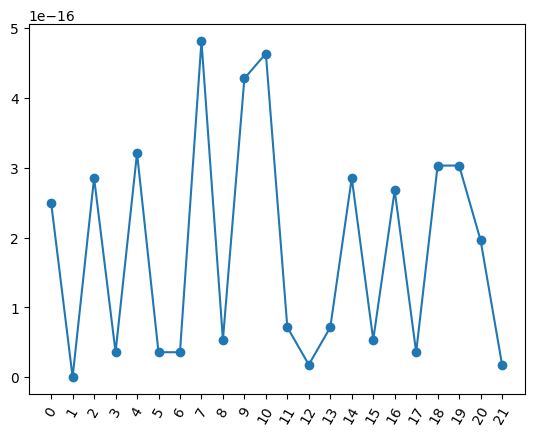

In [1158]:
# for a in peers:
#     print(len(a.bitcoinTree))
for k,v in blkGenDict.items():
    blkGenDict[k] = v / cnt
import matplotlib.pylab as plt
lists = sorted(blkGenDict.items())
x, y = zip(*lists)
plt.plot(x, y,'-o')
plt.xticks(x, rotation=60)
plt.show()

In [849]:
sum=0
for a in range(10000):
    sum +=np.random.exponential(scale=meanTime)

In [850]:
sum/1e+4

1.9945568494555028

In [881]:
sum=0
for a in range(10000):
    aTime =0
    cij = 1e+8
    ij = np.random.uniform(1e-2,0.5)
    dij = np.random.exponential(scale= (96e+3/cij))
    newTime = aTime + ij + (8e+3/cij) + dij
    sum +=newTime

In [882]:
sum/1e+4

0.2544985188488099

In [883]:
sum=0
for a in range(10000):
    aTime =0
    cij = 5e+6
    ij = np.random.uniform(1e-2,0.5)
    dij = np.random.exponential(scale= (96e+3/cij))
    newTime = aTime + ij + (8e+3/cij) + dij
    sum +=newTime

In [884]:
sum/1e+4

0.27616161434749154

In [896]:
0.255 +  8e+6/5e+6 + 96e+3/5e+6 


1.8742

In [893]:
len(peers)

29

In [897]:
29 * 2

58